# Week 7 - HMM Implementation

In [1]:
#matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import boxcox
from hmmlearn.hmm import GaussianHMM as hm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### (1) Load the data from HMMobs.csv and plot the observations.

You'll need to figure out an time axis vector for the data (it was recorded starting from midnight at even intervals over 24 hours).

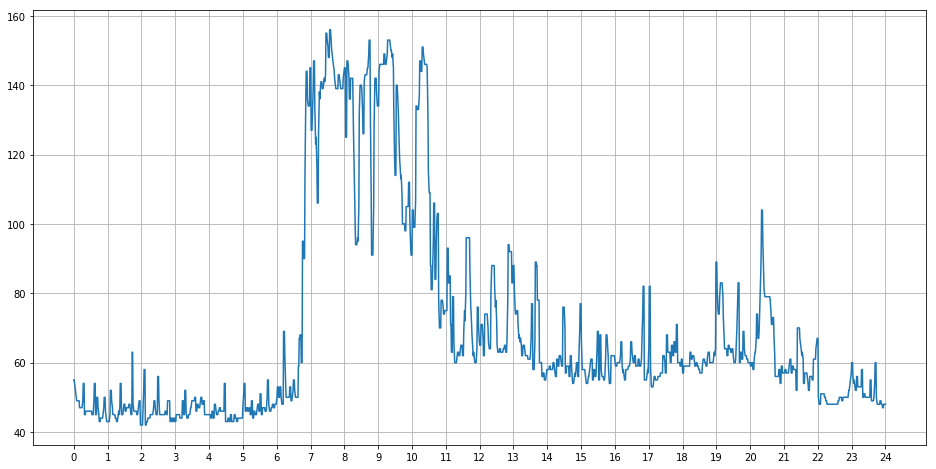

In [2]:
hr = np.loadtxt("./wk7_HR.csv")
time = np.linspace(0, 24, 1974)
plt.figure(figsize = (16,8))
plt.xticks(np.linspace(0,24,25))
plt.plot(time, hr)
plt.grid()

#### (2) Do you see regions where there might be differences in behavior?

Yes, there is a large increase in heart rate between the hours of roughly 6:30 and 10:30 in the morning. Additionally, the heart rate after 11am and before 10pm is higher than that between 10pm and 6:30am, indicating that the person is probably awake but not asleep. 

#### (3) Based on when you might expect someone would be asleep, plot the histogram of resting heart rate values.

Given the shape of this distribution, do you think any transformation of the data would be helpful?

(array([113., 192., 201.,  72.,  46.,  19.,   7.,   6.,   2.,   1.]),
 array([42. , 44.5, 47. , 49.5, 52. , 54.5, 57. , 59.5, 62. , 64.5, 67. ]),
 <a list of 10 Patch objects>)

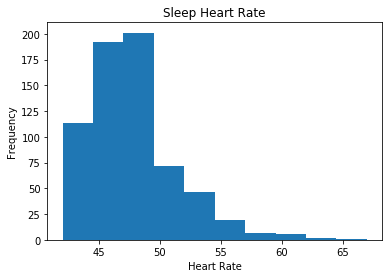

In [3]:
#get the interval to be from hour 22 to hour 7 
hr_sleep = []

for n in range(0,len(hr)):
    curr_t = time[n]
    curr_hr = hr[n]
    if curr_t < 6 or curr_t > 22:
        hr_sleep.append(curr_hr);
        
plt.title("Sleep Heart Rate")
plt.xlabel("Heart Rate")
plt.ylabel("Frequency")
plt.hist(hr_sleep)

Because the histogram is skewed towards higher heart rate values, it appears to be exponentially decreasing. Therefore, doing a log transform on the data would probably be informative. 

Text(0, 0.5, 'Frequency')

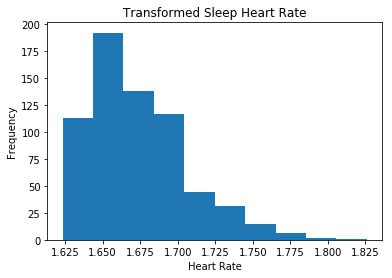

In [4]:
hr_sleepTransform = [np.log10(x) for x in hr_sleep]
plt.hist(hr_sleepTransform)

plt.title("Transformed Sleep Heart Rate")
plt.xlabel("Heart Rate")
plt.ylabel("Frequency")

Although the data appears to be less skewed, it is still not a totally normal distribution.

#### (4) One way to deal with noisy data is to use a moving average. Plot the moving average of the data for two different windows. How does this help visualize the data? What is lost using this approach?

Text(0, 0.5, 'Average Heart Rate')

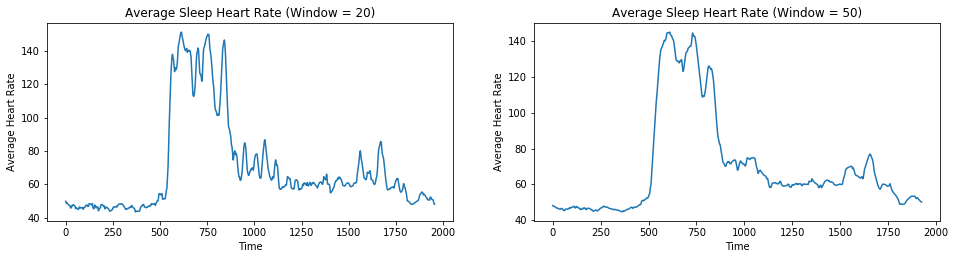

In [5]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

plt.figure(figsize = (16,8))

plt.subplot(221)
plt.plot(movingaverage(hr, 20));
plt.title("Average Sleep Heart Rate (Window = 20)")
plt.xlabel("Time")
plt.ylabel("Average Heart Rate")

plt.subplot(222)
plt.plot(movingaverage(hr, 50));
plt.title("Average Sleep Heart Rate (Window = 50)")
plt.xlabel("Time")
plt.ylabel("Average Heart Rate")

This helps visualize the data because there's a lot less noise when looking at this data, as the line is thinner and you only see every couple points so the information doesn't jump around as much. However, we do lose data that is indicative of the instantaneous changes that occur. This is because it takes a lot longer for an average to increase than individual points

#### (5) We're going to fit an HMM model to this data with three underlying states. This involves three sets of parameters about the model—describe each briefly.

The three sets of parameters about the model are the starting, transition, and emission probabilities for being in each state. The starting probabilities make up the probabilities of starting in a certain condition (i.e. the probability you're in the sleeping, active, or awake state). The transition probabilities are the probabilities that you'll transition from one of the three states to another one of the three states. Because the states are initially hidden to the viewer, the emission probabilities are the probabilities that the specific state is output at a certain point in time. 

#### (6) Fit an HMM model with Gaussian emissions to the data. Use any transformations as necessary.

How does the model respond to rapid state changes? Overlay the raw measurements and HMM state over time.

[[1.672909  ]
 [2.0277478 ]
 [1.77827885]]
[2 2 2 ... 0 0 0]


Text(0, 0.5, 'Heart Rate')

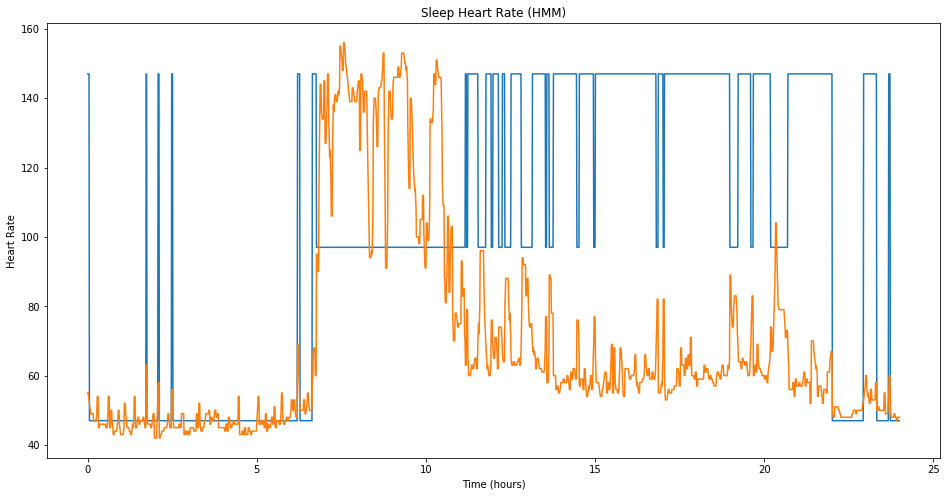

In [6]:
# Reshape the data 
hr_Transform = [np.log10(x) for x in hr]
hr_reshape = np.array(hr_Transform).reshape(-1,1)

# Make an HMM instance and execute fit
modelPred = hm(n_components=3, n_iter=10000, tol=0.00001).fit(hr_reshape)


# Use EM to fit the parameters of a model
hiddenStates = modelPred.predict(hr_reshape);

# startprob_, transmat_, means_, _covars_
print(modelPred.means_)
print(hiddenStates)

plt.figure(figsize = (16,8))
plt.plot(time, 50*hiddenStates + 47)
plt.plot(time,hr)
plt.title("Sleep Heart Rate (HMM)")
plt.xlabel("Time (hours)")
plt.ylabel("Heart Rate")

I had to scale and adjust the HMMM states slightly in order to make the most meaning out of the overlay. Because the hidden states were 0, 1, and 2, I multiplied by 50 so that I could easily distinguish between the different states on my graph. Furthermore, I added 47 to each of the states because the lowest mean heart rate was approximately 47, and this made reading the graph easier. This model does not respond too well to rapid state changes, as it jumps from the hidden state 2 (most likely sleeping) to hidden state 0 (most likely awake) with small spikes in the data. This means that it is reading the small spike as a high probability that the patient is entering a different state, whereas qualitively looking at the data tells us otherwise. However, as a whole, the model does a pretty good job of predicting the state. 

#### (7) From the HMM model determine, with a confidence interval, when the patient woke up in the morning. Compare this prediction to the data you obtain with the moving average.

Hint: `model.predict_proba(X)` can give you the probability of being in each state at each time point.

Text(0, 0.5, 'Ratio')

<Figure size 432x288 with 0 Axes>

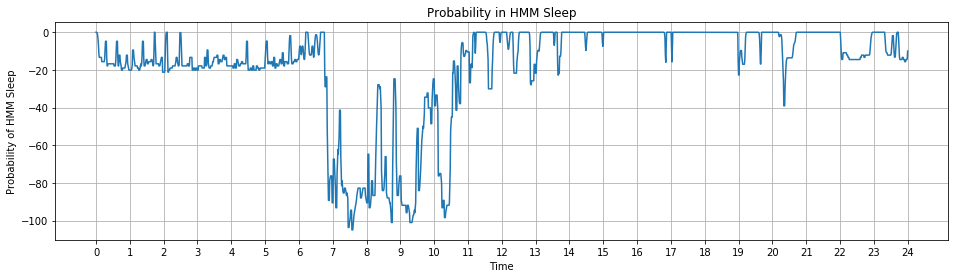

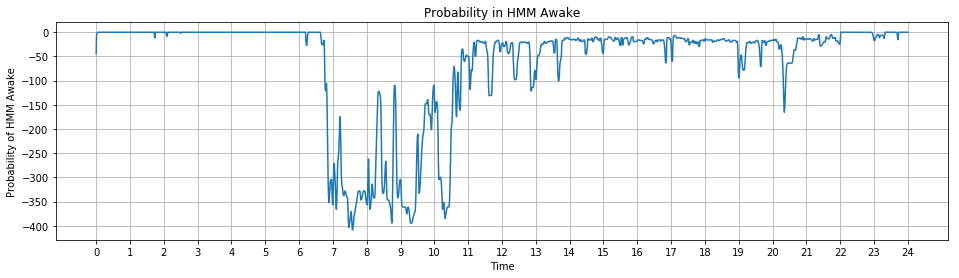

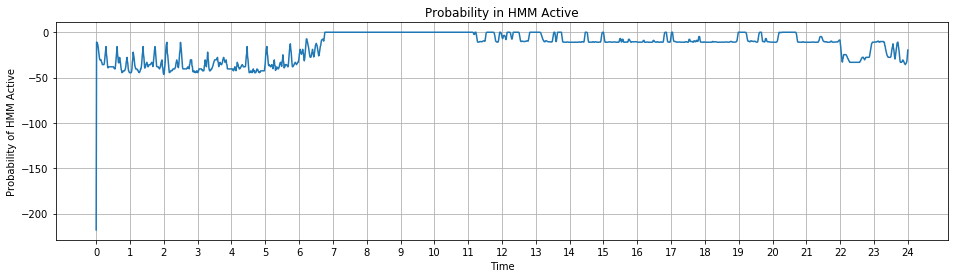

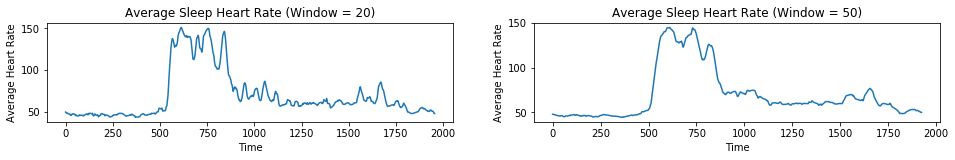

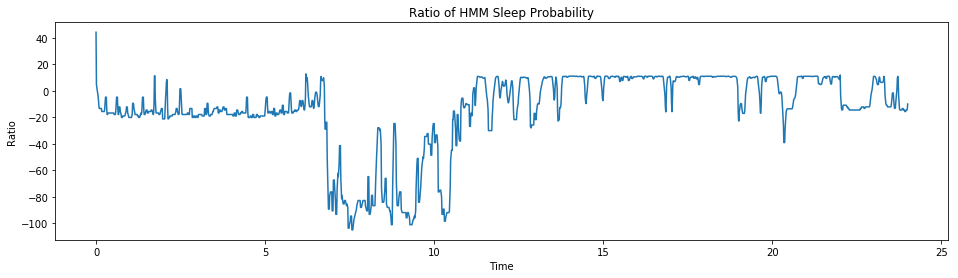

In [7]:
probability = modelPred.predict_proba(hr_reshape) 
pSleep = probability[:,2]
pActive = probability[:,1]
pAwake = probability[:,0]

probSleep = np.log((pSleep)/(pAwake + pActive))

plt.figure(1)
plt.figure(figsize = (16,4))
plt.xticks(np.linspace(0,24,25))
plt.plot(time, np.log(pSleep))
plt.grid()
plt.title("Probability in HMM Sleep")
plt.xlabel("Time")
plt.ylabel("Probability of HMM Sleep")

plt.figure(2)
plt.figure(figsize = (16,4))
plt.xticks(np.linspace(0,24,25))
plt.plot(time, np.log(pAwake))
plt.grid()
plt.title("Probability in HMM Awake")
plt.xlabel("Time")
plt.ylabel("Probability of HMM Awake")

plt.figure(3)
plt.figure(figsize = (16,4))
plt.xticks(np.linspace(0,24,25))
plt.plot(time, np.log(pActive))
plt.grid()
plt.title("Probability in HMM Active")
plt.xlabel("Time")
plt.ylabel("Probability of HMM Active")


plt.figure(4)
plt.figure(figsize = (16,4))

plt.subplot(221)
plt.plot(movingaverage(hr, 20));
plt.title("Average Sleep Heart Rate (Window = 20)")
plt.xlabel("Time")
plt.ylabel("Average Heart Rate")

plt.subplot(222)
plt.plot(movingaverage(hr, 50));
plt.title("Average Sleep Heart Rate (Window = 50)")
plt.xlabel("Time")
plt.ylabel("Average Heart Rate")

plt.figure(5)
plt.figure(figsize = (16,4))
plt.plot(time,probSleep)
plt.title("Ratio of HMM Sleep Probability")
plt.xlabel("Time")
plt.ylabel("Ratio")

Shown above are the three graphs depicting the probability the patient was in the specific state (with the moving averages inserted from earlier). The probabilities match the moving average graph pretty closely. For example, there is a 0 percent chance probability that the patient is in his "sleep" mode when the moving average graph shows a spike in the heart rate. Additionally, there is a 0 percent probability that the patient is in his "active" mode when the moving average heart rate is low. From this data, we can assume that the patient woke up when the probability that he is in "sleep" mode drops to zero, or just before 7am. 

#### (8) Describe one form of other information you could use from a smart watch to make a more accurate determination of the user's state.

How would you use that in your model?

Another form of information I could use from a smart watch would be the movement of the user in their environment. It stands to reason that the more active a person is, the more their body is moving as well. I could implement this in my model by doing a linear combination of this data along with my heart rate data in order to analyze the hidden markov model with multiple parameters.